In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import LinearRegression

# Round 4

In [2]:
price_0 = pd.read_csv('../data/raw/round_4/prices_round_4_day_1.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_4/prices_round_4_day_2.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_4/prices_round_4_day_3.csv', delimiter=';')
price_0 = price_0[price_0['product'] == 'MAGNIFICENT_MACARONS']
price_1 = price_1[price_1['product'] == 'MAGNIFICENT_MACARONS']
price_2 = price_2[price_2['product'] == 'MAGNIFICENT_MACARONS']

In [3]:
trades_0 = pd.read_csv('../data/raw/round_4/trades_round_4_day_1.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_4/trades_round_4_day_2.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_4/trades_round_4_day_3.csv', delimiter=';')
trades_0 = trades_0[trades_0['symbol'] == 'MAGNIFICENT_MACARONS']
trades_1 = trades_1[trades_1['symbol'] == 'MAGNIFICENT_MACARONS']
trades_2 = trades_2[trades_2['symbol'] == 'MAGNIFICENT_MACARONS']

In [4]:
obs_0 = pd.read_csv('../data/raw/round_4/observations_round_4_day_1.csv', delimiter=',')
obs_1 = pd.read_csv('../data/raw/round_4/observations_round_4_day_2.csv', delimiter=',')
obs_2 = pd.read_csv('../data/raw/round_4/observations_round_4_day_3.csv', delimiter=',')

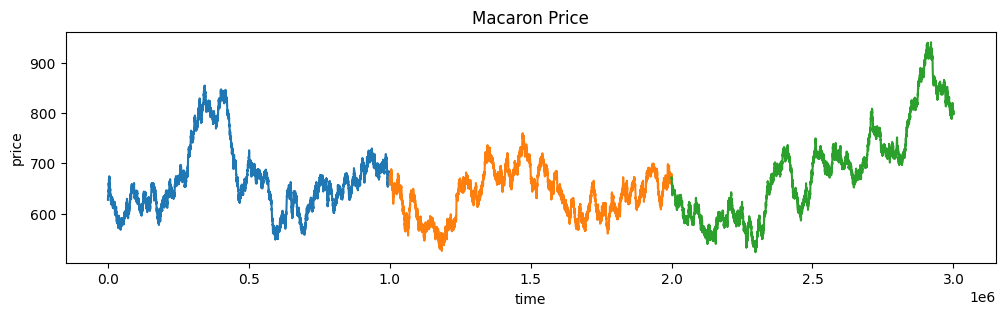

In [5]:
plt.figure(figsize=(12, 3))
plt.plot(price_0['timestamp'], price_0['mid_price'])
plt.plot(price_1['timestamp'] + 1000000, price_1['mid_price'])
plt.plot(price_2['timestamp'] + 2000000, price_2['mid_price'])
plt.title('Macaron Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [6]:
prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)
observations = pd.concat([obs_0, obs_1, obs_2], axis=0).reset_index(drop=True)

In [7]:
observations

,timestamp,bidPrice,askPrice,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex
0,0,627.0,628.5,1.0,9.0,-3.0,200.000000,60.00
1,100,630.0,631.5,1.0,9.0,-3.0,200.098445,60.00
2,200,630.0,631.5,1.0,9.0,-3.0,200.103915,60.00
3,300,632.0,633.5,1.0,9.0,-3.0,200.352462,60.01
4,400,630.5,632.0,1.0,9.0,-3.0,200.201545,60.01
...,...,...,...,...,...,...,...,...
29995,999500,797.5,799.0,1.7,9.5,-5.5,212.124918,54.95
29996,999600,801.5,803.0,1.7,9.5,-5.5,212.147650,54.96
29997,999700,804.0,805.5,1.7,9.5,-5.5,212.202086,54.97
29998,999800,798.5,800.0,1.7,9.5,-5.5,212.112734,54.98


In [8]:
observations['sunlightIndex'].max(), observations['sunlightIndex'].min()

(np.float64(70.0), np.float64(20.0))

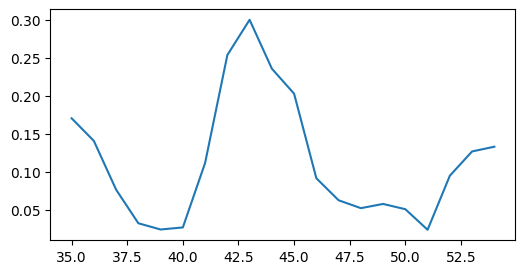

In [9]:
corrs = []
x = range(35, 55)
for csi in x:
    inds = observations['sunlightIndex'][observations['sunlightIndex'] < csi].index
    sugar = observations['sugarPrice'].loc[inds]
    mac = prices['mid_price'].loc[inds]
    corr1 = np.corrcoef(sugar, mac)[0, 1]

    inds = observations['sunlightIndex'][observations['sunlightIndex'] > csi].index
    sugar = observations['sugarPrice'].loc[inds]
    mac = prices['mid_price'].loc[inds]
    corr2 = np.corrcoef(sugar, mac)[0, 1]

    corrs.append(abs(corr1 - corr2))

plt.figure(figsize=(6, 3))
plt.plot(x, corrs)
plt.show()

In [10]:
csi = x[np.argmax(corrs)]
csi = 45
print(f'CSI: {csi}')

CSI: 45


In [11]:
observations['sunlightIndex'].diff().dropna().unique()

array([ 0.  ,  0.01,  0.01,  0.01, -0.02, -0.02, -0.03, -0.03, -0.02,
       -0.03, -0.03, -0.02, -0.03,  0.04,  0.03,  0.03,  0.04,  0.03,
        0.04, -0.01, -0.01,  0.02,  0.02,  0.02, -0.01])

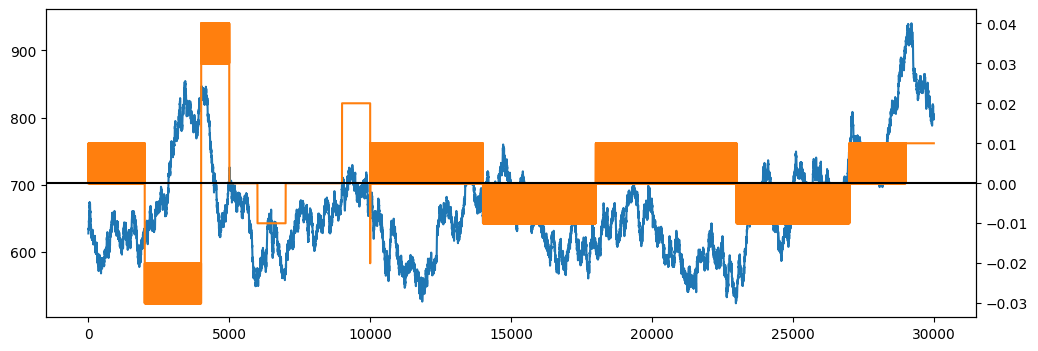

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
ax2 = ax.twinx()
ax.plot(prices['mid_price'])
ax2.plot(observations['sunlightIndex'] - observations['sunlightIndex'].shift(1), c='tab:orange')
ax2.axhline(0, c='k')
plt.xlabel('time')
plt.show()

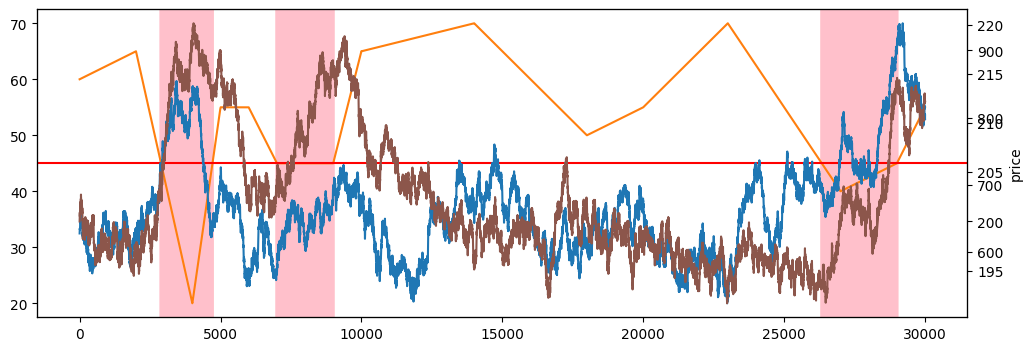

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
ax2 = ax.twinx()
ax3 = ax.twinx()
for idx in observations['sunlightIndex'][observations['sunlightIndex'] <= csi].index:
    ax.axvline(idx, c='pink')
ax.plot(observations['sunlightIndex'], c='tab:orange')
ax.axhline(csi, c='r')
ax2.plot(prices['mid_price'])
ax3.plot(observations['sugarPrice'], c='tab:brown')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [12]:
bid_prices = prices[['bid_price_1', 'bid_price_2', 'bid_price_3']].to_numpy()
max_inds = prices[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_bid_prices = bid_prices[np.arange(len(bid_prices)), max_inds]

ask_prices = prices[['ask_price_1', 'ask_price_2', 'ask_price_3']].to_numpy()
max_inds = prices[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_ask_prices = ask_prices[np.arange(len(ask_prices)), max_inds]

prices = prices.assign(pop_bid_price=pop_bid_prices)
prices = prices.assign(pop_ask_price=pop_ask_prices)
prices = prices.assign(pop_mid_price=(pop_bid_prices + pop_ask_prices) / 2)

In [13]:
prices['bid_price_1'].isna().sum(), prices['bid_price_2'].isna().sum(), prices['bid_price_3'].isna().sum()

(np.int64(0), np.int64(0), np.int64(0))

In [14]:
prices['ask_price_1'].isna().sum(), prices['ask_price_2'].isna().sum(), prices['ask_price_3'].isna().sum()

(np.int64(0), np.int64(0), np.int64(0))

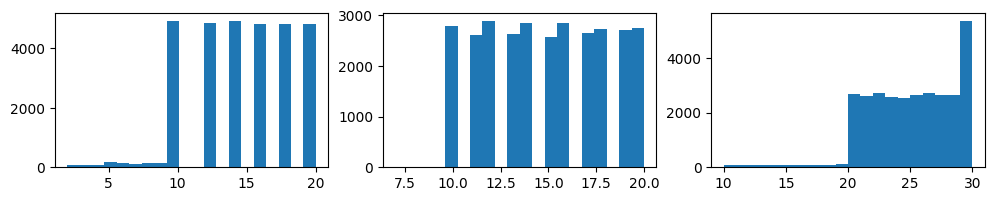

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(prices['bid_volume_1'], bins=20)
ax[1].hist(prices['bid_volume_2'], bins=20)
ax[2].hist(prices['bid_volume_3'], bins=20)
plt.show()

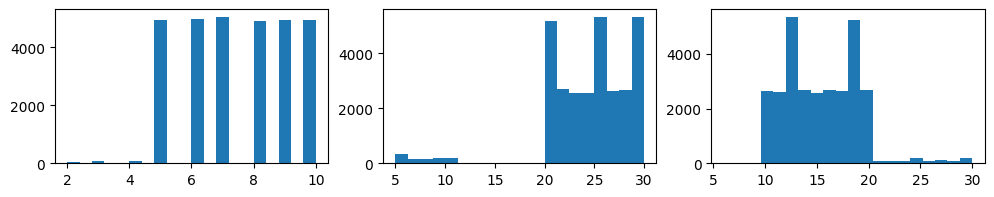

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(prices['ask_volume_1'], bins=20)
ax[1].hist(prices['ask_volume_2'], bins=20)
ax[2].hist(prices['ask_volume_3'], bins=20)
plt.show()

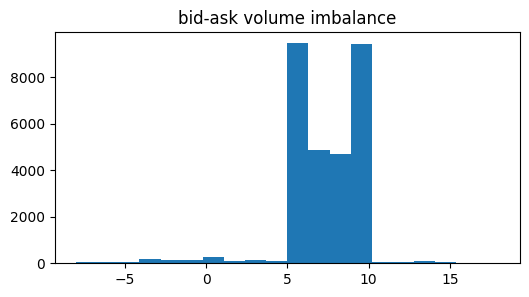

In [17]:
plt.figure(figsize=(6, 3))
plt.hist(prices['bid_volume_1'] - prices['ask_volume_1'], bins=20)
plt.title('bid-ask volume imbalance')
plt.show()

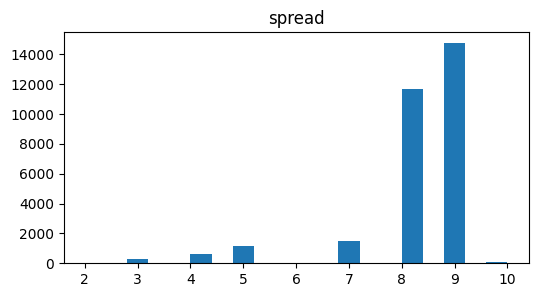

In [18]:
plt.figure(figsize=(6, 3))
plt.hist(prices['ask_price_1'] - prices['bid_price_1'], bins=20)
plt.title('spread')
plt.show()

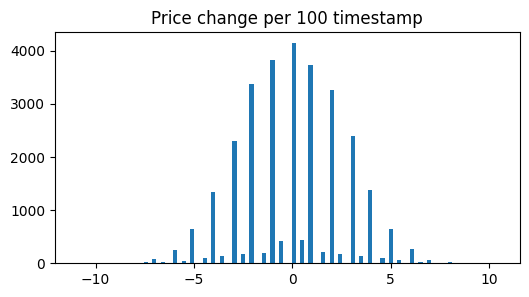

In [19]:
plt.figure(figsize=(6, 3))
plt.hist(prices['mid_price'] - prices['mid_price'].shift(1), bins=100)
plt.title('Price change per 100 timestamp')
plt.show()

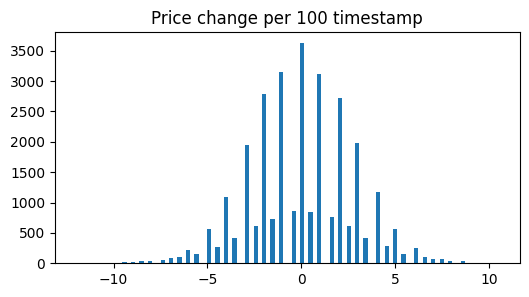

In [20]:
plt.figure(figsize=(6, 3))
plt.hist(prices['pop_mid_price'] - prices['pop_mid_price'].shift(1), bins=100)
plt.title('Price change per 100 timestamp')
plt.show()

In [38]:
price = prices.iloc[1000:1010]

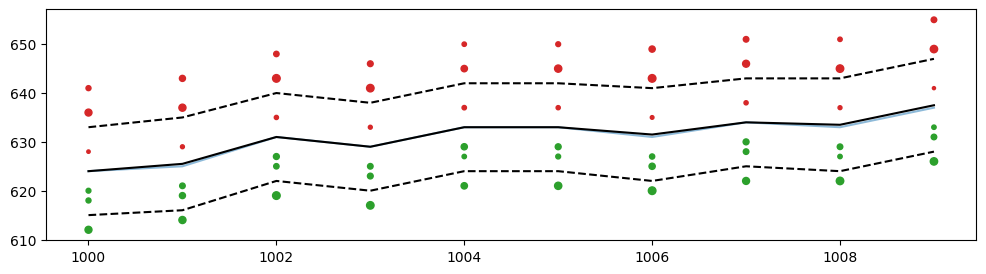

In [39]:
plt.figure(figsize=(12, 3))
plt.scatter(price['timestamp']//100, price['bid_price_1'], s=price['bid_volume_1'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_2'], s=price['bid_volume_2'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_3'], s=price['bid_volume_3'], c='tab:green')
plt.scatter(price['timestamp']//100, price['ask_price_1'], s=price['ask_volume_1'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_2'], s=price['ask_volume_2'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_3'], s=price['ask_volume_3'], c='tab:red')
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue', alpha=0.5)
plt.plot(price['timestamp']//100, price['pop_mid_price'], c='k')
plt.plot(price['timestamp']//100, np.floor(price['pop_mid_price']) - 9, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['pop_mid_price']) + 9, c='k', linestyle='dashed')
plt.show()

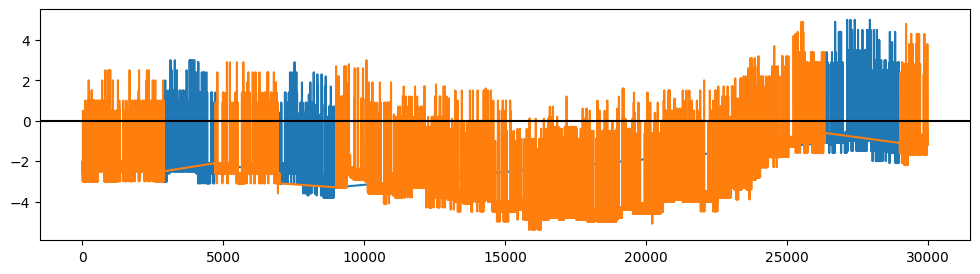

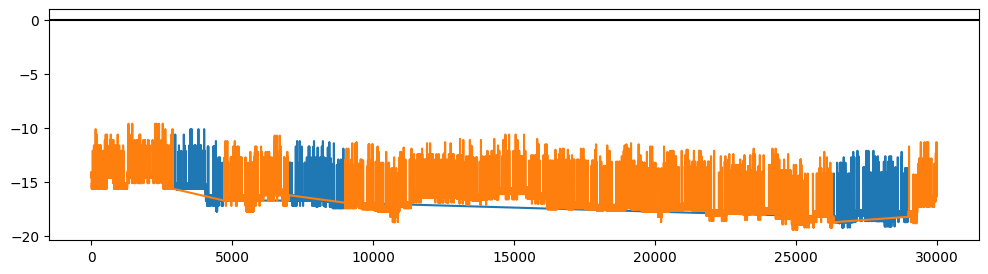

In [40]:
inds_low = observations['sunlightIndex'][observations['sunlightIndex'] <= csi].index
inds_high = observations['sunlightIndex'][observations['sunlightIndex'] > csi].index

bids_1 = prices['bid_price_1']
bids_2 = prices['bid_price_2']
asks = prices['ask_price_1']
implied_bids = observations['bidPrice'] - observations['exportTariff'] - observations['transportFees'] - 0.1
implied_asks = observations['askPrice'] + observations['importTariff'] + observations['transportFees']

bids_1_low = bids_1.loc[inds_low]
bids_2_low = bids_2.loc[inds_low]
asks_low = asks.loc[inds_low]
implied_bids_low = implied_bids.loc[inds_low]
implied_asks_low = implied_asks.loc[inds_low]

bids_1_high = bids_1.loc[inds_high]
bids_2_high = bids_2.loc[inds_high]
asks_high = asks.loc[inds_high]
implied_bids_high = implied_bids.loc[inds_high]
implied_asks_high = implied_asks.loc[inds_high]

plt.figure(figsize=(12, 3))
plt.plot(bids_1_low - implied_asks_low)
plt.plot(bids_1_high - implied_asks_high)
plt.axhline(0, c='k')
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(implied_bids_low - asks_low)
plt.plot(implied_bids_high - asks_high)
plt.axhline(0, c='k')
plt.show()

## Price prediction - mid price

In [67]:
lags = range(-1000, 1001)

In [68]:
corrs_sugar = []
for lag in lags:
    if lag > 0:
        corrs_sugar.append(np.corrcoef(prices['mid_price'][lag:], observations['sugarPrice'][:-lag])[0, 1])
    elif lag < 0:
        corrs_sugar.append(np.corrcoef(observations['sugarPrice'][-lag:], prices['mid_price'][:lag])[0, 1])
    else:
        corrs_sugar.append(np.corrcoef(prices['mid_price'], observations['sugarPrice'])[0, 1])

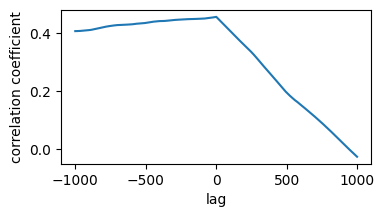

In [69]:
plt.figure(figsize=(4, 2))
plt.plot(lags, corrs_sugar)
plt.xlabel('lag')
plt.ylabel('correlation coefficient')
plt.show()

In [70]:
corrs_sun = []
for lag in lags:
    if lag > 0:
        corrs_sun.append(np.corrcoef(prices['mid_price'][lag:], observations['sunlightIndex'][:-lag])[0, 1])
    elif lag < 0:
        corrs_sun.append(np.corrcoef(observations['sunlightIndex'][-lag:], prices['mid_price'][:lag])[0, 1])
    else:
        corrs_sun.append(np.corrcoef(prices['mid_price'], observations['sunlightIndex'])[0, 1])

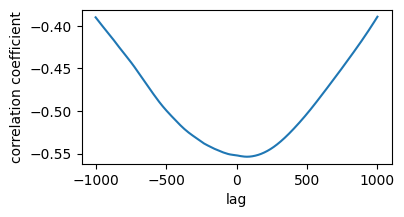

In [71]:
plt.figure(figsize=(4, 2))
plt.plot(lags, corrs_sun)
plt.xlabel('lag')
plt.ylabel('correlation coefficient')
plt.show()

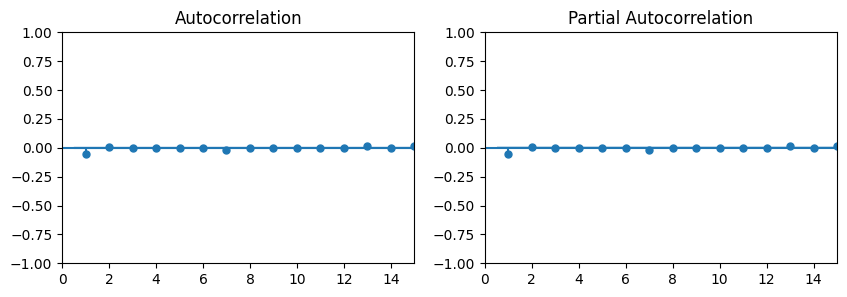

In [72]:
logr = np.log(prices['mid_price'] / prices['mid_price'].shift(1)).dropna()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(logr, ax=ax[0], zero=False)
plot_pacf(logr, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
plt.show()

In [73]:
x = observations[['sugarPrice', 'sunlightIndex']].iloc[:-1].reset_index(drop=True)
x['macaronPrice'] = prices['mid_price'].iloc[:-1].reset_index(drop=True)
x = x.to_numpy()
x = x[1:, :] - x[:-1, :]

y = prices['mid_price'].iloc[1:].to_numpy()
y = y[1:] - y[:-1]

### Naive

In [74]:
err = y[10000:]
print(f'RMSE: {np.sqrt(np.mean(err ** 2))}')

RMSE: 2.5870894463045375


### Linear regression - One feature

In [75]:
model = LinearRegression()
model.fit(np.expand_dims(x[:10000, 2], axis=-1), y[:10000])

LinearRegression()

In [76]:
model.coef_

array([-0.04441811])

In [77]:
pred = model.predict(np.expand_dims(x[10000:, 2], axis=-1))
err = y[10000:] - pred
print(f'RMSE: {np.sqrt(np.mean(err ** 2))}')

RMSE: 2.5827053710680783


### Linear Regression - Three features

In [78]:
model = LinearRegression()
model.fit(x[:10000, :], y[:10000])

LinearRegression()

In [79]:
model.coef_

array([ 0.79726342, -3.40293535, -0.07936455])

In [80]:
pred = model.predict(x[10000:])

In [81]:
err = y[10000:] - pred
print(f'RMSE: {np.sqrt(np.mean(err ** 2))}')

RMSE: 2.5800473680597404


# Round 5

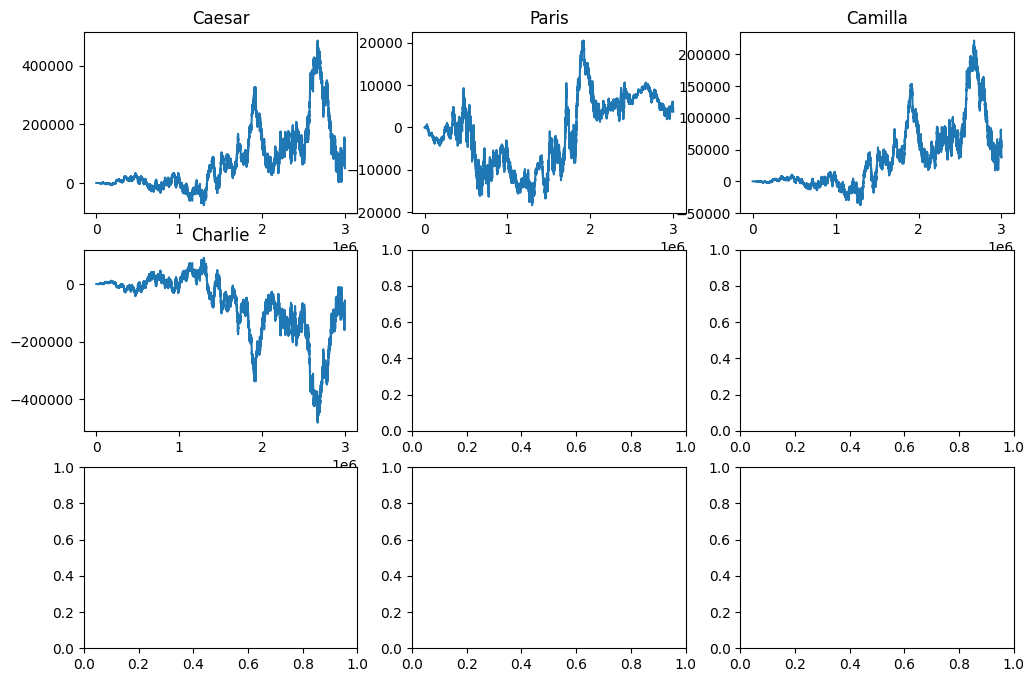

In [10]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'MAGNIFICENT_MACARONS']
price_1 = price_1[price_1['product'] == 'MAGNIFICENT_MACARONS']
price_2 = price_2[price_2['product'] == 'MAGNIFICENT_MACARONS']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'MAGNIFICENT_MACARONS']
trades_1 = trades_1[trades_1['symbol'] == 'MAGNIFICENT_MACARONS']
trades_2 = trades_2[trades_2['symbol'] == 'MAGNIFICENT_MACARONS']

price_1['timestamp'] += 1_000_000
price_2['timestamp'] += 2_000_000
trades_1['timestamp'] += 1_000_000
trades_2['timestamp'] += 2_000_000

prices = pd.concat([price_0, price_1, price_2], axis=0).set_index('timestamp', drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).set_index('timestamp', drop=True)

bots = list(trades['buyer'].unique())

fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    position = bot_trades.apply(lambda x: x['quantity'] if x['buyer'] == bot else -x['quantity'], axis=1)
    position = position.groupby(position.index).sum().cumsum()
    position.loc[0] = 0
    prices['position'] = position
    prices['position'] = prices['position'].ffill()
    prices['pnl'] = prices['position'].shift(1) * prices['mid_price'].diff()
    prices['pnl'] = prices['pnl'].cumsum()
    
    ax.plot(prices['pnl'])
    ax.set_title(bot)
plt.show()

In [11]:
def calculate_cumulative_pnl(df, buy_times, sell_times):
    df['buy'] = 0
    df['sell'] = 0
    df.loc[buy_times, 'buy'] = 1
    df.loc[sell_times, 'sell'] = 1
    
    df["long_position"] = (df["buy"] * df["ask_volume_1"]).cumsum()

    # Average entry price for the long side (volume-weighted)
    df["long_cost"] = (df["buy"] * df["ask_volume_1"] * df["ask_price_1"]).cumsum()
    
    # Average price of long holdings (VWAP)
    df["avg_long_price"] = df["long_cost"] / df["long_position"]
    df["avg_long_price"] = df["avg_long_price"].fillna(0)
    
    # Long PnL = holding size × (current mid - avg buy price)
    df["long_pnl"] = df["long_position"] * (df["mid_price"] - df["avg_long_price"])
    
    # Same logic for short positions
    df["short_position"] = (df["sell"] * df["bid_volume_1"]).cumsum()
    df["short_cost"] = (df["sell"] * df["bid_volume_1"] * df["bid_price_1"]).cumsum()
    df["avg_short_price"] = df["short_cost"] / df["short_position"]
    df["avg_short_price"] = df["avg_short_price"].fillna(0)
    
    # Short PnL = short size × (avg sell price - current mid)
    df["short_pnl"] = df["short_position"] * (df["avg_short_price"] - df["mid_price"])
    
    # Total unrealized PnL
    df["pnl"] = df["long_pnl"] + df["short_pnl"]
    return df["pnl"]

In [12]:
results = {}
for b1 in bots:
    for b2 in bots:
        for b3 in bots:
            for b4 in bots:
                buy_idx = trades[(trades['buyer'] == b1) & (trades['seller'] == b2)].index + 100
                sell_idx = trades[(trades['buyer'] == b3) & (trades['seller'] == b4)].index + 100
                pnl = calculate_cumulative_pnl(prices, buy_idx, sell_idx)
                results[(b1, b2, b3, b4)] = pnl.iloc[-1] / pnl.diff().std() if pnl.diff().std() > 0 else 0

In [13]:
max(results.values())

np.float64(115.44523508059396)

In [14]:
[k for k, v in results.items() if v == max(results.values())][0]

('Camilla', 'Caesar', 'Paris', 'Paris')

<Axes: xlabel='timestamp'>

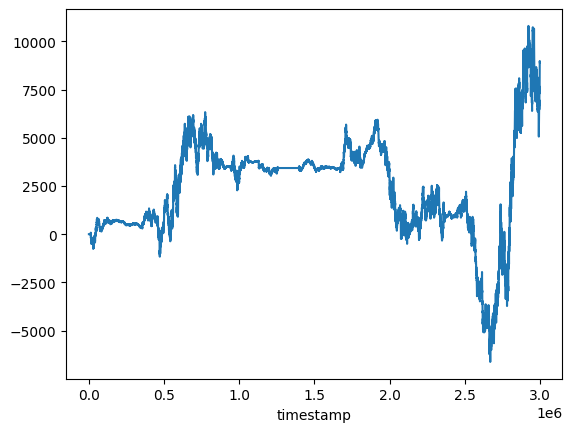

In [15]:
b1, b2, b3, b4 = [k for k, v in results.items() if v == max(results.values())][0]

buy_idx = trades[(trades['buyer'] == b1) & (trades['seller'] == b2)].index + 100
sell_idx = trades[(trades['buyer'] == b3) & (trades['seller'] == b4)].index + 100
pnl = calculate_cumulative_pnl(prices, buy_idx, sell_idx)

pnl.plot()